In [54]:
# %load ../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrix
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline
plt.style.use('seaborn-white')

In [78]:
wage_data = pd.read_csv('Wage.csv')
wage_data.head(5)

,Unnamed: 0,year,age,sex,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,231655,2006,18,1. Male,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,86582,2004,24,1. Male,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,161300,2003,45,1. Male,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,155159,2003,43,1. Male,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,11443,2005,50,1. Male,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154


# Lab 7.8.1:  Polynomial Regression and Step Functions

In [79]:
X_1 = PolynomialFeatures(1).fit_transform(wage_data.age.values.reshape(-1,1))
X_2 = PolynomialFeatures(2).fit_transform(wage_data.age.values.reshape(-1,1))
X_3 = PolynomialFeatures(3).fit_transform(wage_data.age.values.reshape(-1,1))
X_5 = PolynomialFeatures(5).fit_transform(wage_data.age.values.reshape(-1,1))

In [80]:
X_4 = PolynomialFeatures(4).fit_transform(wage_data.age.values.reshape(-1,1))
gls_fit2 = sm.GLS(wage_data.wage, X_4).fit()
gls_fit2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
const,-184.1542,60.040,-3.067,0.002,-301.879,-66.430
x1,21.2455,5.887,3.609,0.000,9.703,32.788
x2,-0.5639,0.206,-2.736,0.006,-0.968,-0.160
x3,0.0068,0.003,2.221,0.026,0.001,0.013
x4,-3.204e-05,1.64e-05,-1.952,0.051,-6.42e-05,1.45e-07


In [63]:
# adding a response matrix
response_y = (wage_data.wage > 250).map({False:0, True:1}).as_matrix()

# fitting the logical selected model. 
clf = sm.GLM(response_y, X_4, family=sm.families.Binomial(sm.families.links.logit))
res = clf.fit()

In [64]:
# age values over the range
age_grid_over_range = np.arange(wage_data.age.min(), wage_data.age.max()).reshape(-1,1)

# Creating test data
X_test = PolynomialFeatures(4).fit_transform(age_grid_over_range)

# Predict vales of the selected ages
pred1 = gls_fit2.predict(X_test) # salary
pred2 = res.predict(X_test)  # Pr(wage>250)

Text(0, 0.5, 'Pr(wage>250|age)')

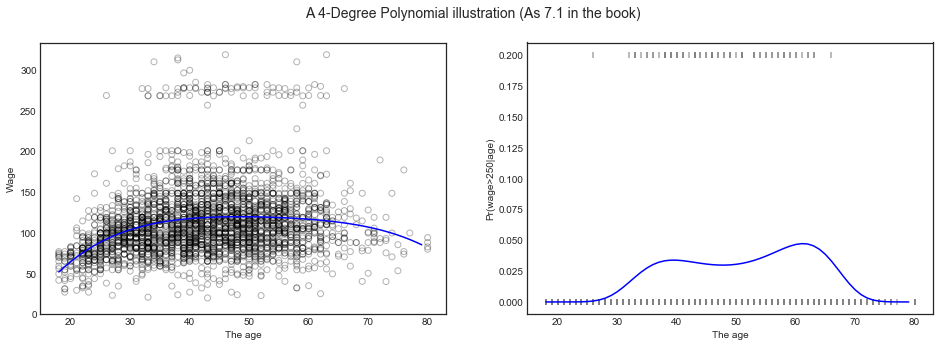

In [66]:
# Creating the plots as they are in fig. 7.1 in the books
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (16,5))
fig.suptitle('A 4-Degree Polynomial illustration (As 7.1 in the book)', fontsize=14)

# Scatter plot using poly. regression.
#The solid blue curve is a degree-4 polynomial of wage (in thousands of dollars) as a function of age, fit by least squares.
ax1.scatter(wage_data.age, wage_data.wage, facecolor='None', edgecolor='k', alpha=0.3)
ax1.plot(age_grid_over_range, pred1, color = 'b')
ax1.set_ylim(ymin=0)
ax1.set_xlabel('The age')
ax1.set_ylabel('Wage')

# Logistic regression showing Pr(wage>250) for the selected age range.
ax2.plot(age_grid_over_range, pred2, color='b')

# Rug plot showing the distribution of wage>250 in the training data.
# 'True' on the top, 'False' on the bottom.
ax2.scatter(wage_data.age, y/5, s=30, c='grey', marker='|', alpha=0.7)

ax2.set_ylim(-0.01,0.21)
ax2.set_xlabel('The age')
ax2.set_ylabel('Pr(wage>250|age)')

# hypothesis tests and ANOVA

In [69]:
fit_0 = fit = sm.GLS(df.wage, X1).fit()
fit_1 = fit = sm.GLS(df.wage, X2).fit()
fit_2 = fit = sm.GLS(df.wage, X3).fit()
fit_3 = fit = sm.GLS(df.wage, X4).fit()
fit_4 = fit = sm.GLS(df.wage, X5).fit()

print(sm.stats.anova_lm(fit_1, fit_2, fit_3, fit_4, fit_5, typ=1))

   df_resid           ssr  df_diff       ss_diff         F    Pr(>F)
0    2997.0  4.793430e+06      0.0           NaN       NaN       NaN
1    2996.0  4.777674e+06      1.0  15755.693664  9.888756  0.001679
2    2995.0  4.771604e+06      1.0   6070.152124  3.809813  0.051046
3    2994.0  4.770322e+06      1.0   1282.563017  0.804976  0.369682
4    2994.0  4.770322e+06     -0.0     -0.000000       NaN       NaN


# Step functions

In [71]:
wage_data_cut, bins = pd.cut(df.age, 4, retbins = True, right = True)
wage_data_cut.value_counts(sort = False)

(17.938, 33.5]     750
(33.5, 49.0]      1399
(49.0, 64.5]       779
(64.5, 80.0]        72
Name: age, dtype: int64

In [72]:
wage_data_steps = pd.concat([wage_data.age, wage_data_cut, wage_data.wage], keys = ['age','age_cuts','wage'], axis = 1)

# Dummy variables for the different age groups
wage_data_steps_dummies = pd.get_dummies(wage_data_steps['age_cuts'])

# Adding explicit of a intercept ( constant)
wage_data_steps_dummies = sm.add_constant(wage_data_steps_dummies)

# Drop the (17.938, 33.5] category
wage_data_steps_dummies = wage_data_steps_dummies.drop(df_steps_dummies.columns[1], axis = 1)

wage_data_steps_dummies.head(5)

,const,"(17.938, 33.5]","(49.0, 64.5]","(64.5, 80.0]"
0,1.0,1,0,0
1,1.0,1,0,0
2,1.0,0,0,0
3,1.0,0,0,0
4,1.0,0,1,0


In [73]:
gls_fit3 = sm.GLM(wage_data_steps.wage, wage_data_steps_dummies).fit()
gls_fit3.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
const,118.2119,1.081,109.379,0.000,116.094,120.330
"(17.938, 33.5]",-24.0535,1.829,-13.148,0.000,-27.639,-20.468
"(49.0, 64.5]",-0.3889,1.807,-0.215,0.830,-3.931,3.153
"(64.5, 80.0]",-16.4129,4.885,-3.360,0.001,-25.987,-6.838


Text(0, 0.5, 'Pr(wage>250|age)')

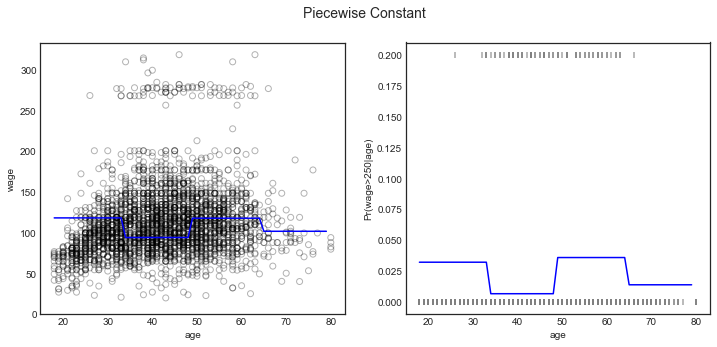

In [74]:
# Put the test data in the same bins as the training data.
bin_mapping = np.digitize(age_grid_over_range.ravel(), bins)

# Get dummies, drop first dummy category, add constant
X_test2 = sm.add_constant(pd.get_dummies(bin_mapping).drop(1, axis = 1))

# Predict the value of the generated ages using the linear model
pred2 = gls_fit3.predict(X_test2)

# And the logistic model
clf2 = sm.GLM(response_y, wage_data_steps_dummies,
              family=sm.families.Binomial(sm.families.links.logit))
res2 = clf2.fit()
pred3 = res2.predict(X_test2)

# Plot
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12,5))
fig.suptitle('This is an illustration of Piecewise Constant', fontsize = 14)

# Scatter plot with polynomial regression line
ax1.scatter(wage_data.age, wage_data.wage, facecolor = 'None', edgecolor = 'k', alpha = 0.3)
ax1.plot(age_grid, pred2, c = 'b')

ax1.set_xlabel('age')
ax1.set_ylabel('wage')
ax1.set_ylim(ymin = 0)

# Logistic regression showing Pr(wage>250) for the age range.
ax2.plot(np.arange(df.age.min(), df.age.max()).reshape(-1,1), pred3, color = 'b')

# Rug plot showing the distribution of wage>250 in the training data.
# 'True' on the top, 'False' on the bottom.
ax2.scatter(df.age, y/5, s = 30, c = 'grey', marker = '|', alpha = 0.7)

ax2.set_ylim(-0.01, 0.21)
ax2.set_xlabel('age')
ax2.set_ylabel('Pr(wage>250|age)')